This code is inspired from https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/elasticity.plate.html. More precisely, we copied it, than change some code to fit on our diffusion case. It works well without any problem (in any cases the plot seems good)

In [1]:
pip list

Package            Version
------------------ ------------
anyio              4.2.0
astor              0.8.1
asttokens          2.4.1
certifi            2024.2.2
charset-normalizer 2.1.1
colorama           0.4.6
comm               0.2.1
common             0.1.2
contourpy          1.2.0
cycler             0.12.1
debugpy            1.8.1
decorator          5.1.1
DeepXDE            1.10.1
executing          2.0.1
filelock           3.9.0
fonttools          4.48.1
fsspec             2023.4.0
h11                0.14.0
httpcore           1.0.2
httpx              0.26.0
idna               3.6
ipykernel          6.29.2
ipython            8.21.0
jedi               0.19.1
Jinja2             3.1.2
joblib             1.3.2
jupyter_client     8.6.0
jupyter_core       5.7.1
kiwisolver         1.4.5
MarkupSafe         2.1.3
matplotlib         3.8.2
matplotlib-inline  0.1.6
mpmath             1.3.0
nest-asyncio       1.6.0
networkx           3.2.1
numpy              1.26.2
opt-einsum         3.3.0
pac

In [17]:
#TIme dependent example of the presentation
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import os
os.environ['DDE_BACKEND'] = 'pytorch'
import torch

In [18]:


# Check if CUDA (GPU) is available and set default tensor type to cuda, but I haven't installed cuda yet
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("/////////////////\n Tensors type on GPU \n///////////////")
else:
  print("/////////////////\n Tensors type on CPU \n///////////////")
# USE_GPU = True
# device = torch.device('cuda') if (USE_GPU and torch.cuda.is_available()) else torch.device('cpu')
# print(device)


/////////////////
 Tensors type on CPU 
///////////////


In [22]:
"""Backend supported: pytorch, paddle

Implementation of the linear elasticity 2D example in paper https://doi.org/10.1016/j.cma.2021.113741.
References:
    https://github.com/sciann/sciann-applications/blob/master/SciANN-Elasticity/Elasticity-Forward.ipynb.
"""
import deepxde as dde
import numpy as np


sin = torch.sin
cos = torch.cos

end_time = 1

geom = dde.geometry.Rectangle([0, 0], [1, 1])
timedomain = dde.geometry.TimeDomain(0, end_time)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def boundary_left(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0.0)


def boundary_right(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1.0)


def boundary_top(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 1.0)


def boundary_bottom(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 0.0)


def boundary_time(x, on_initial):
    # print(x)
    return on_initial and dde.utils.isclose(x[2], 0.0)




C_top_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_top)
C_bottom_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_bottom)
C_left_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_left)
C_right_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_right)
initial_condition = dde.icbc.IC(geomtime, lambda x:0, boundary_time)



def close_to_source(p):
    Square_middle = torch.tensor([0.5, 0.5], dtype=torch.float)
    return (torch.isclose(p[:, 0], Square_middle[0], atol=1/10, rtol=0) * torch.isclose(p[:, 1], Square_middle[1], atol=1/10, rtol=0)).view((-1, 1))


def pde(p, C):
    """residual of the pde
    p contains the spatial coordinates x, y and the time t
    the i-th point (xi, yi, ti) is stored in p in the i-th line and we have
    p[i, 0] = xi; p[i, 1] = yi; p[i, 2] = ti
    C corresponds to C(p) the concentration at p"""

    dC_x = dde.grad.jacobian(C, p, j=0)
    dC_y = dde.grad.jacobian(C, p, j=1)
    dC_t = dde.grad.jacobian(C, p, j=2)

    dC_xx = dde.grad.hessian(C, p, i=0, j=0)
    dC_yy = dde.grad.hessian(C, p, i=1, j=1)



    D= 0.001


    return (
        - dC_t
        - 1 * dC_x
        - 1 * dC_y
        + D * (dC_xx + dC_yy)  + close_to_source(p)*1.0
    )


data = dde.data.TimePDE(
    geomtime,
    pde,
    [C_top_bc,
     C_bottom_bc,
     C_left_bc,
     C_right_bc,
     initial_condition,
    ],
    num_domain=500,
    num_boundary=500,
    num_initial = 200,
    num_test=100,
)

layers = [3] + [40] *3 + [1]
activation = "tanh"
# activation = ["tanh"] * 3 + ["Relu"] #Some exponential activation to forc positive Concentration
initializer = "Glorot uniform"
net = dde.nn.FNN(layers, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# dde.saveplot(losshistory, train_state, issave=True, isplot=True)

KeyError: 'exp'

In [20]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.colors

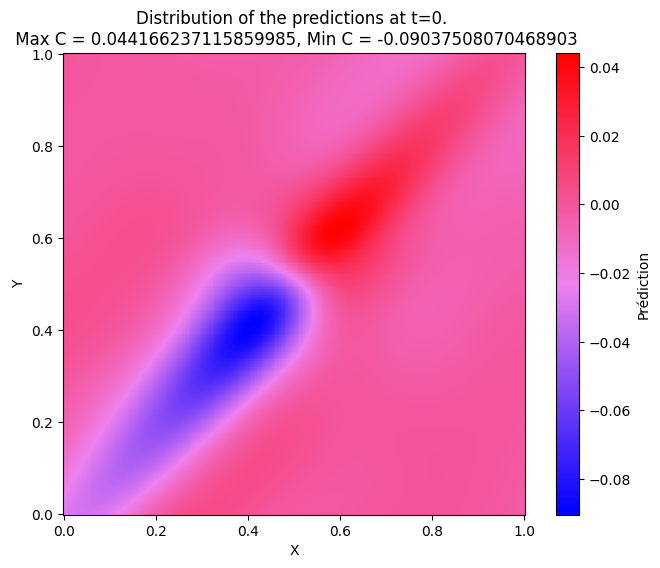

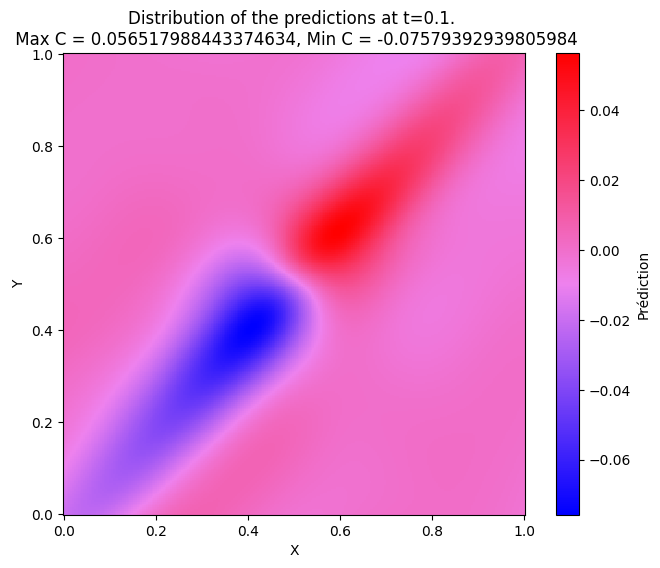

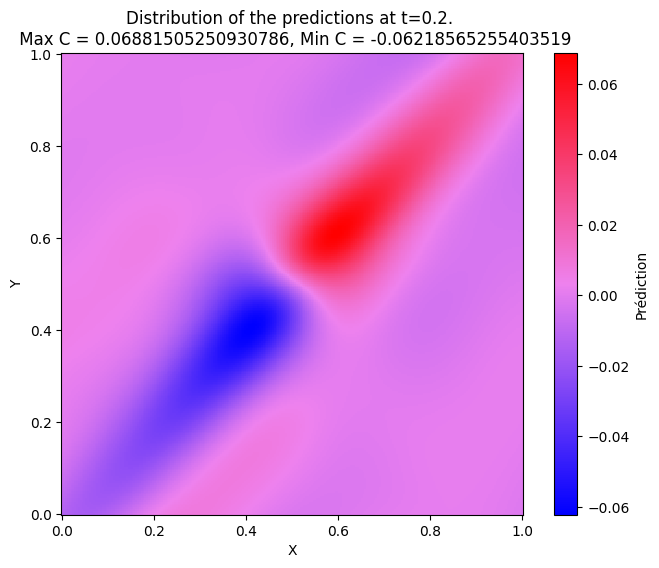

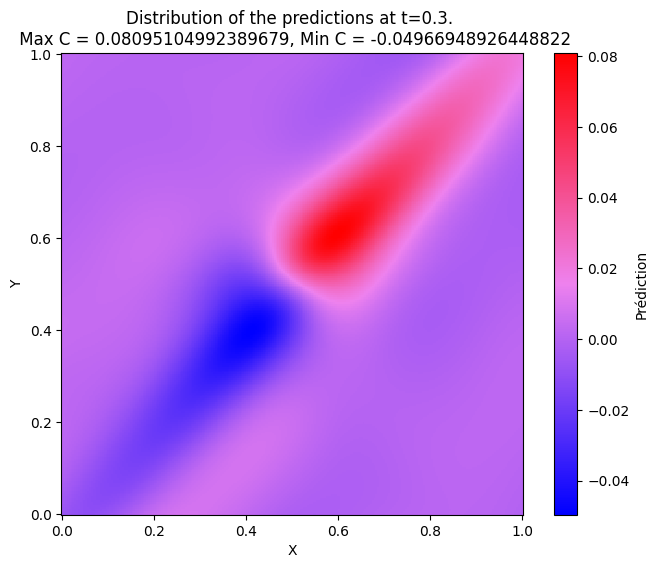

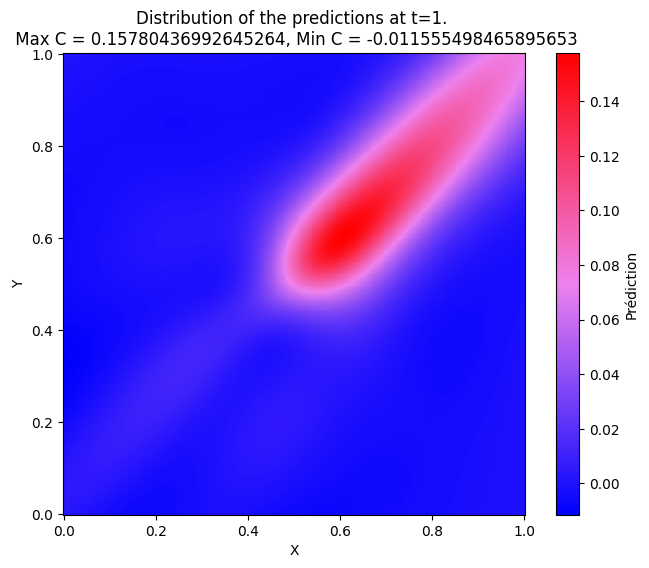

In [21]:
#Code Arnaud
# Test: on affiche le resultat au temps t
Lx=1
Ly=1

time_list = [0, 0.1, 0.2, 0.3, 1]
x = geom.uniform_points(250 * 250, True)
C_max = 0.7 #Max in absolute value to scale the color of the graph
Use_max = False
resolution_mesh = 250
xi = np.linspace(0, Lx, resolution_mesh)
yi = np.linspace(0, Ly, resolution_mesh)
xi, yi = np.meshgrid(xi, yi)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", ["blue", "violet", "red"]
)


for t in time_list:
    p = np.c_[x, np.array([t] * x.shape[0])]
    y = model.predict(p)

    zi = griddata((x[:, 0], x[:, 1]), y[:, 0], (xi, yi), method="linear")

    plt.figure(figsize=(8, 6))
    if Use_max:
        plt.pcolormesh(xi, yi, zi, cmap=cmap, vmin=-1*C_max, vmax=C_max, shading="auto")
    else:
        plt.pcolormesh(xi, yi, zi, cmap=cmap, shading="auto")
    plt.colorbar(label="Prédiction")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Distribution of the predictions at t={time}. \n Max C = {max}, Min C = {min}".format(time=t, max = np.max(y), min = np.min(y)))

    plt.gca().set_aspect('equal', adjustable='box') # Set aspect ratio to have a rectangular plot
    plt.show()
    

Some remarks on the computation of the solution and the plot:
*  In "y = model.predict(p, operator=pde)", the "operator = pde" part gives weird results so we don't write it. 
*  The plot with constant Concentration scale hides the diffusion when there's a high cocentration variation. 

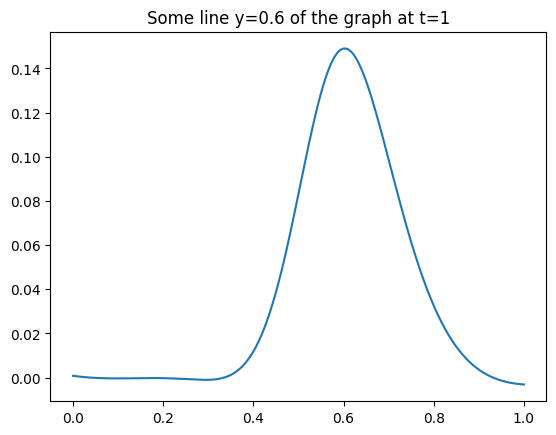

In [16]:
#Verification on some t fixed and y fixed line of the plot

y = 0.6
x = np.linspace(0, 1, 1000)
t = 1

P = np.array([[x, y, t] for x in np.linspace(0, 1, 1000)])
C = model.predict(P)

plt.plot(x, C)
plt.title("Some line y={ordinate} of the graph at t={time}".format(time=t, ordinate = y))
plt.show()
